<div style="text-align: right"><strong>Capstone #3:</strong> <span style="color:darkred">Supervised Learning</span> </div>

<a id="top"></a>

#### </span>__Part 1: Data Exploration__ https://github.com/kimrharper/thinkful/blob/master/unit3/unit3-capstone-exploration.ipynb </span><br><br><span>__Part 2: Analysis__ https://github.com/kimrharper/thinkful/blob/master/unit3/unit3-capstone-analysis.ipynb </span><br><br><span>__Part 3: Models__ https://github.com/kimrharper/thinkful/blob/master/unit3/unit3-capstone-models.ipynb </span>

----

# <span style="color:darkred">L1 Prediction from ELL Writing Samples</span>

### <span style="color:darkred">Part 3: </span><span style="color:darkblue">Models</span>

__Author:__ Ryan Harper 

----

<a href='#ov'>Overview</a><br>
<a href='#exp'>Experiment</a><br>
<a href='#sec1'>1. Models:</a><br>
><a href='#seca'>A. LR - Ordinary Least Squares</a><br>
<a href='#secb'>B. LR - Logistic Regression</a> <a href='#secb1'> (Lasso)</a> <a href='#secb2'> (Ridge)</a><br>
<a href='#secc'>C. NN - K Nearest Neighbors</a><br>
<a href='#secd'>D. NN - Naive Bayes</a><br>
<a href='#sece'>E. NN - Decision Tree</a><br>
<a href='#secf'>F. Ensemble - Random Forest</a><br>

<a href='#sec2'>2. Model Comparison</a><br>

<a id="sec1"></a>

# <span style="color:darkblue">1. Models:</span>  <a href='#top'>(top)</a>

In [1]:
# iPython/Jupyter Notebook
import time
from pprint import pprint
import warnings
from IPython.display import Image

import time

# Data processing
import pandas as pd
import plotly as plo
import seaborn as sns
from scipy import stats
from collections import Counter
import numpy as np
import itertools

# NLP
from nltk.corpus import stopwords as sw
from nltk.util import ngrams
from nltk.corpus import brown
import nltk
import re
from nltk.tokenize import RegexpTokenizer
import difflib

# Stats
from sklearn.metrics import classification_report, roc_curve,roc_auc_score,accuracy_score
from sklearn import metrics

# Preparing Models
from sklearn.model_selection import train_test_split

# Decomposition
from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import sparse_random_matrix

# Models
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.naive_bayes import BernoulliNB,MultinomialNB,GaussianNB
from sklearn.neural_network import MLPClassifier

# Ensemble
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

#Visualization
from IPython.display import Image
import pydotplus
import graphviz
import matplotlib.pyplot as plt

# import altair as alt

__Import Features + Target__

In [2]:
loadf = False
if loadf:
    features = pd.read_csv('blogfeatures.csv').sample(frac=1.0)
    del features['Unnamed: 0']
else:
    %store -r blog
    %store -r keepfeatures
    features = blog

lang = list(features.language.unique())

In [3]:
del features['id']
del features['content']
del features['pos']
del features['pos2']
del features['pos3']
del features['tokens']

In [4]:
features.language.value_counts()

Japanese               9536
Traditional Chinese    3407
Name: language, dtype: int64

__Set X,Y__ (UNUSED)

__Select Features:__ Features with biggest differences between L1s

In [5]:
selectfeatures = True
if selectfeatures:
    nonbinary = ['letters_per','wc','sc','sent_pol','sent_subj','cap_let','punc_count','freq_score','full_freq_score']
    best_features = keepfeatures + nonbinary
else:
    best_features = features.columns[~features.columns.str.contains('language')]

__Truncated SVD:__ Determine best features

In [6]:
svdbool = False
if svdbool:
    svd = TruncatedSVD(n_components=20, n_iter=7, random_state=42)
    svd.fit(features[best_features])
    # print(svd.explained_variance_ratio_)
    # print(svd.explained_variance_ratio_.sum())  
    # print(svd.singular_values_)
    # svd.get_params
    # best_features = [X.columns[i] for i in svd.components_[0].argsort()[::-1]]

__Split Data to Train/Test__: Even Distribution Sampling

In [7]:
# evenly_distributed_test = [60 japanese,60 english, 60 chinese, 60 korean]
langlist = []
rs=21
for l in lang:
    print(l)
    langlist.append(features[features['language'] == l].sample(n=200, random_state=rs))

testset = langlist

Traditional Chinese
Japanese


In [8]:
test_data = pd.concat(testset)
y_test = test_data['language'].values.reshape(-1, 1).ravel()
X_test = test_data[best_features]

In [9]:
%%time
train_data = features[~features.isin(test_data)].dropna()
y_train = train_data['language'].values.reshape(-1, 1).ravel()
X_train = train_data[best_features]
# X_train = svd.transform(train_data[train_data.columns[~train_data.columns.str.contains('language')]])

CPU times: user 21.4 s, sys: 8.26 s, total: 29.6 s
Wall time: 29.4 s


<a id="seca"></a>

__Create Function for Comparing Models__

In [10]:
cols = ['name','time','total','precision','recall','f1']

model_set = pd.DataFrame(columns=cols)
models_stored = []
pattern = "%.2f"

In [32]:
def run_model(model,name):
    global model_set
    m = model
    m.fit(X_train, y_train)
    start = time.time()

    total_score = m.score(X_test,y_test)
    pscore = [pattern % i for i in list(metrics.precision_score(y_test, m.predict(X_test),labels=lang,average=None))]
    rscore = [pattern % i for i in list(metrics.recall_score(y_test, m.predict(X_test),labels=lang,average=None))]
    fscore = [pattern % i for i in list(metrics.f1_score(y_test, m.predict(X_test),labels=lang,average=None))]
    end = time.time()
    t= pattern % (end - start)
    cvs = cross_val_score(m, X_test,y_test)

    r = dict(zip(cols,[name,t,total_score,pscore,rscore,fscore]))
    print('Check for Overfitting: {}\n'.format(m.score(X_train,y_train)))
    print('Test Score is: {}\n'.format(total_score))
    print(classification_report(y_test, m.predict(X_test)))
    print('')
    print('Cross Val Score: {} | Avg: {} '.format(cvs,cvs.sum()/len(cvs)))
    print('')
    
    model_set = model_set.append(r,ignore_index=True)
    return r,m

<a id="seca"></a>

### <span style="color:darkred">A. LR - Logistic Regression</span>  <a href='#top'>(top)</a>

> Target is binary so logistic regression will operate on probabilities

In [33]:
%%time
lreg_data,lreg = run_model(linear_model.LogisticRegression(),'Logistic Regression')

Check for Overfitting: 0.7455951526747987

Test Score is: 0.51

                     precision    recall  f1-score   support

           Japanese       0.51      1.00      0.67       200
Traditional Chinese       1.00      0.02      0.04       200

        avg / total       0.75      0.51      0.36       400


Cross Val Score: [0.71641791 0.73134328 0.75757576] | Avg: 0.7351123172018695 

CPU times: user 252 ms, sys: 25.8 ms, total: 278 ms
Wall time: 224 ms


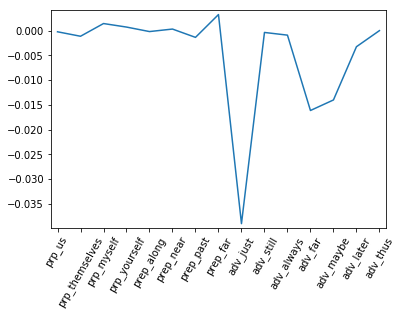

In [13]:
lreg_coef = lreg.coef_[0][560:]

# Plot the coefficients
plt.plot(range(len(X_train.columns[560:])), lreg_coef)
plt.xticks(range(len(X_train.columns[560:])), X_train.columns, rotation=60)
plt.margins(0.02)
plt.show()

<a id="sece"></a>

### <span style="color:darkred">E. K Nearest Neighbors</span>  <a href='#top'>(top)</a>

> Can handle discrete values for target <br>Quantitative values are limited (not continuous) and might be problematic for nearest neighbors

In [14]:
%%time
neighbors_data,neighbors = run_model(KNeighborsClassifier(n_neighbors=8),'K Nearest Neighbor')

Check for Overfitting: 0.753647452762497

Test Score is: 0.5025

                     precision    recall  f1-score   support

           Japanese       0.50      0.97      0.66       200
Traditional Chinese       0.55      0.03      0.06       200

        avg / total       0.52      0.50      0.36       400

CPU times: user 2.2 s, sys: 47.1 ms, total: 2.25 s
Wall time: 2.2 s


<a id="secf"></a>

### <span style="color:darkred">F. Naive Bayes - Bernoulli</span>  <a href='#top'>(top)</a>

In [34]:
%%time
bnb_data,bnb = run_model(BernoulliNB(),'Naive Bayes - Bernoulli')

Check for Overfitting: 0.7950251136091844

Test Score is: 0.71

                     precision    recall  f1-score   support

           Japanese       0.66      0.87      0.75       200
Traditional Chinese       0.81      0.55      0.65       200

        avg / total       0.73      0.71      0.70       400


Cross Val Score: [0.69402985 0.6641791  0.67424242] | Avg: 0.677483793155435 

CPU times: user 274 ms, sys: 86.5 ms, total: 360 ms
Wall time: 389 ms


Stored 'bnb_sorted' (list)


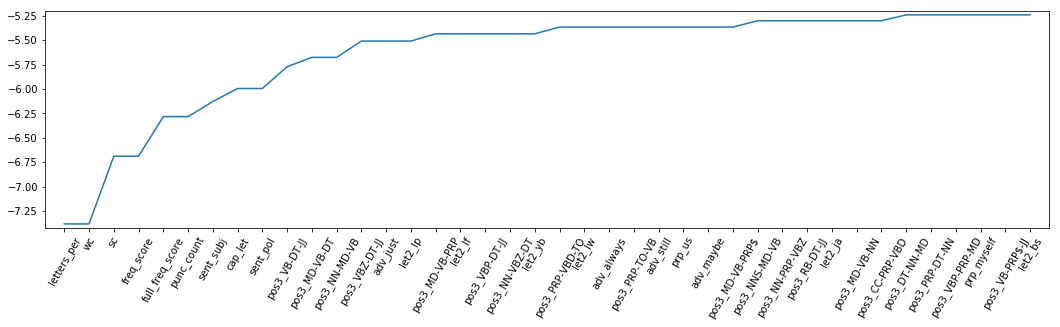

In [16]:
importance = dict(list(zip(X_train.columns,bnb.coef_[0])))
bnb_sorted = sorted(importance, key=importance.get, reverse=True)
%store bnb_sorted

bnb_coef = []
for r in bnb_sorted:
    bnb_coef.append(importance[r])
    
bnb_coef = bnb_coef[::-1]

# Plot the coefficients
plt.figure(figsize=(18,4))
plt.plot(range(len(bnb_coef[0:40])), bnb_coef[0:40])
plt.xticks(range(len(bnb_coef[0:40])), bnb_sorted[0:40], rotation=60)
plt.margins(0.02)
plt.show()

<a id="secg"></a>

### <span style="color:darkred">G. Decision Tree</span>  <a href='#top'>(top)</a>

In [17]:
%%time
dt_data,dt = run_model(tree.DecisionTreeClassifier(criterion='entropy',max_depth=4),'Decision Tree')

Check for Overfitting: 0.7766084668739536

Test Score is: 0.565

                     precision    recall  f1-score   support

           Japanese       0.54      0.99      0.69       200
Traditional Chinese       0.93      0.14      0.24       200

        avg / total       0.73      0.56      0.47       400

CPU times: user 195 ms, sys: 15.9 ms, total: 211 ms
Wall time: 211 ms


In [18]:
# Render tree.
dot_data = tree.export_graphviz(
    dt, 
    out_file=None,
    feature_names=X_train.columns,
    label= 'root',
    proportion=False,
    rounded=True,
    class_names=lang,
    filled=True
)

graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

graph.write_png('decision_tree.png')

True

_Good visualization of important features and presentation of entropy weighting_

<a id="sech"></a>

### <span style="color:darkred">H. Random Forest</span>  <a href='#top'>(top)</a>

> Runs decision tree multiple times for best output <br>Longest processing time

In [19]:
%%time
rf_data,rf = run_model(ensemble.RandomForestClassifier(n_estimators=150,
                                                       criterion='entropy',
                                                       max_features=len(X_train.columns),
                                                       max_depth=6),'Random Forest')

Check for Overfitting: 0.8189428366419517

Test Score is: 0.65

                     precision    recall  f1-score   support

           Japanese       0.59      0.98      0.74       200
Traditional Chinese       0.95      0.32      0.47       200

        avg / total       0.77      0.65      0.61       400

CPU times: user 22.3 s, sys: 178 ms, total: 22.4 s
Wall time: 22.6 s


In [20]:
rf.feature_importances_
importance = dict(list(zip(X_train.columns,rf.feature_importances_)))
rf_sorted = sorted(importance, key=importance.get, reverse=True)
for r in rf_sorted[0:5]:
    if importance[r] >0:
        print(r, importance[r])
print('')
%store rf_sorted

let2_ja 0.2565522889939036
sc 0.17862334506660296
wc 0.12987790457557574
cap_let 0.057191992994046925
pos3_NN-MD-VB 0.04282259883215764

Stored 'rf_sorted' (list)


<a id="sech"></a>

### <span style="color:darkred">I. MLPC - Supervised Neural Network</span>  <a href='#top'>(top)</a>

In [21]:
%%time
mlp_data,mlp = run_model(MLPClassifier(hidden_layer_sizes=(400,)),'Neural Network - MLPC')

Check for Overfitting: 0.7443195407797177

Test Score is: 0.5025

                     precision    recall  f1-score   support

           Japanese       0.50      1.00      0.67       200
Traditional Chinese       1.00      0.01      0.01       200

        avg / total       0.75      0.50      0.34       400

CPU times: user 4.97 s, sys: 415 ms, total: 5.38 s
Wall time: 3.02 s


# <span style="color:darkblue">2. Model Comparison</span>  <a href='#top'>(top)</a>

In [22]:
model_set.columns = ['name','time','total','prec: | JA | CH |','rec: | JA | CH |','f1: | JA | CH |']
model_set

,name,time,total,prec: | JA | CH |,rec: | JA | CH |,f1: | JA | CH |
0,Logistic Regression,0.01,0.5100,"[1.00, 0.51]","[0.02, 1.00]","[0.04, 0.67]"
1,K Nearest Neighbor,0.21,0.5025,"[0.55, 0.50]","[0.03, 0.97]","[0.06, 0.66]"
2,Naive Bayes - Bernoulli,0.01,0.7100,"[0.81, 0.66]","[0.55, 0.87]","[0.65, 0.75]"
3,Decision Tree,0.01,0.5650,"[0.93, 0.54]","[0.14, 0.99]","[0.24, 0.69]"
4,Random Forest,0.05,0.6500,"[0.95, 0.59]","[0.32, 0.98]","[0.47, 0.74]"
5,Neural Network - MLPC,0.03,0.5025,"[1.00, 0.50]","[0.01, 1.00]","[0.01, 0.67]"


In [23]:
model_save = model_set

-----